# Test the Experiment and Analysis classes (under development)

In [ ]:
# set up non-QM hardware
import Labber
# connect to server 
client = Labber.connectToServer('localhost') # get list of instruments 
#instruments = client.getListOfInstrumentsString() 
#for instr in instruments: 
#    print(instr) # close connection 

# reset all QDevil channels to 0 V
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))
for n in range(24):
    if n+1 < 10:
        QDevil.setValue("CH0" + str(n+1) + " Voltage", 0.0)
    else:
        QDevil.setValue("CH" + str(n+1) + " Voltage", 0.0)

# Set qubits to desired dc value
QDevil.setValue("CH01 Voltage", 0.6)

# digital attenuators
Vaunix1 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25606'))
Vaunix2 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25607'))
ROI = 32
ROO = 10
Vaunix1.setValue("Attenuation", ROI)
Vaunix2.setValue("Attenuation", ROO)

# TWPA pump
SG = client.connectToInstrument('Rohde&Schwarz RF Source', dict(interface='TCPIP', address='192.168.88.2'))
freq_TWPA = 6326E6;
pwr_TWPA = -10;
SG.setValue('Frequency', freq_TWPA)
SG.setValue('Power', pwr_TWPA)

client.close()

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
import qdac as qdac
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
import datetime 
import os
import time
import warnings
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from qm.octave.octave_manager import ClockMode
from typing import Union
import json
from set_octave import ElementsSettings, octave_settings
from quam import QuAM

warnings.filterwarnings("ignore")

def wait_until_job_is_paused(current_job):
    """
    Waits until the OPX FPGA reaches the pause statement.
    Used when the OPX sequence needs to be synchronized with an external parameter sweep.

    :param current_job: the job object.
    """
    while not current_job.is_paused():
        time.sleep(0.01)
        pass
    return True

qubit_index = 0 # for UA Q1

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")

tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5',year,month,'Data_'+month+day)
if not os.path.exists(tPath):
   os.makedirs(tPath)

2023-10-18 17:36:12,990 - qm - INFO     - Starting session: f4d9bee1-b8e4-463b-88cf-32ecdf9d8aa0


In [2]:
from ExperimentClass import ExperimentHandle

In [3]:
Experiment = ExperimentHandle()

In [ ]:
Experiment.exp1D.RR.rr_freq(np.arange(7E9, 7.1E9, 1e6),0,0,0,100,20E3,Experiment.tPath,Experiment.update_str_datetime,True,1000)

2023-10-18 17:36:19,508 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2023-10-18 17:36:19,512 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-18 17:36:19,528 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-18 17:36:19,784 - qm - INFO     - Simulating program


INFO:qm.api.simulation_api:Simulating program


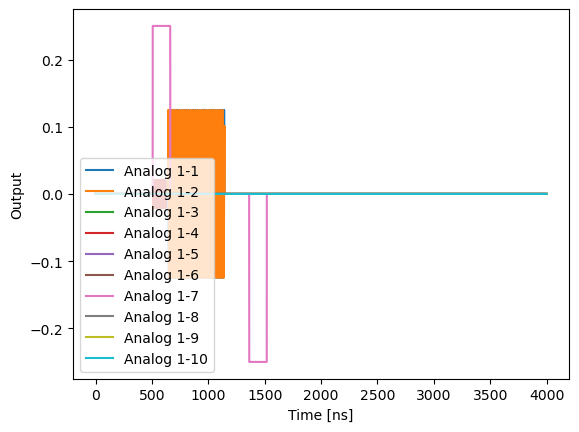

In [4]:
Experiment.exp1D.Rabi.qubit_freq(np.arange(6.5E9, 6.6E9, 1e6),0,0,0,100,20E3,1,Experiment.tPath,Experiment.update_str_datetime,True,1000)